In [1]:
from transformers import AutoTokenizer               

from evaluation.evaluator import EarlyExitEvaluator
from strategies.confidence_exit import ConfidenceExit
from models.gpt2_wrapper import GPT2WithEarlyExit
from evaluation.dataset_loaders.sst2 import load_sst2

tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [2]:
# simple test one sentiment data
strategy = ConfidenceExit(threshold=0.8, allowed_layers=[3,6,9])
model = GPT2WithEarlyExit("gpt2", strategy, tokenizer)

dataset = load_sst2(number=500, task="train")   # Number of data to use = 100, without kv 

evaluator = EarlyExitEvaluator(tokenizer)

result = evaluator.evaluate(
    model=model,
    strategy=strategy,
    dataset=dataset,
    task_type="classification",
    dataset_name="sst2",
)

print(result)

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|█████████████████████████████| 500/500 [00:10<00:00, 45.62it/s]

{'metric': 'accuracy', 'score': np.float64(0.628), 'avg_latency_sec': np.float64(0.02176922369003296), 'tokens_per_sec': 45.93641069790881, 'avg_layers_used': np.float64(6.446), 'num_samples': 500}


### KV-Cache Behavior in Early-Exit GPT-2 Wrapper

Early-exit GPT-2 wrapper supports two execution modes depending on the task.
KV-cache is handled differently for classification vs generation tasks.

#### Classification Tasks (SST-2, AGNews) — No KV-Cache Used

#### Generation Tasks (Summarization, Translation, QA)

For generation, two modes depending on use_kv parameter. 
if use_kv = False (Full Recompute, slow mode)
- Every new token recomputes all layers
- Early exit only skips layers inside one forward pass
- KV-cache is not stored
- Useful for reproducing naive early-exit results

if use_kv = True (KV Vached Early Exit, fast mode)
- step 1: encode the prompt once and produce hidden states for the prompt, KV pair for every layer
- step 2: decode tokens with early exit:
    - for each token run layers sequenctiall..
    - At each layer, compute confidence
        - If early exit triggers at layer L:
        - Layers 0..L compute normally and update KV
        - Layers L+1..final are skipped
        - Their KV is copied forward unchanged

In [4]:
from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.cnn_dm import load_cnndm
from evaluation.dataset_loaders.squad import load_squad
from evaluation.dataset_loaders.wmt_en_fr import load_wmt_enfr

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification")#,
    #("cnn_dm", load_cnndm, "summarization"),
    #("wmt14_enfr", load_wmt_enfr, "translation"),
    #("squad", load_squad, "qa"),
]

evaluator = EarlyExitEvaluator(tokenizer)

# LOAD EACH DATASET ONCE AND CACHE
cached_datasets = {}
print("Loading datasets once...")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=500),
        "task": task
    }

print("All datasets loaded.\n")

results_table = []   # will store all rows

for th in thresholds:
    print(f"\n==============================")
    print(f"Running threshold {th}")
    print(f"==============================")

    strategy = ConfidenceExit(threshold=th, allowed_layers=[2, 4, 6, 8, 10])
    model     = GPT2WithEarlyExit("gpt2", strategy, tokenizer)

    for name, meta in cached_datasets.items():
        task = meta["task"]
        dataset = meta["data"]

        print(f"\nTesting {name} (threshold={th})...")

        if task == "classification":
            result = evaluator.evaluate(
                model=model,
                strategy=strategy,
                dataset=dataset,
                task_type=task,
                dataset_name=name,
            )
        else:
            result = evaluator.evaluate(
                model=model,
                strategy=strategy,
                dataset=dataset,
                task_type=task,
            )

        print(name, result)

        results_table.append({
            "dataset": name,
            #"task": task,
            "threshold": th,
            "metric": result["metric"],
            "score": float(result["score"]),
            "avg_latency_sec": float(result["avg_latency_sec"]),
            "tokens_per_sec": float(result["tokens_per_sec"]),
            "avg_layers_used": float(result["avg_layers_used"]),
            "num_samples": int(result["num_samples"]),
        })

Loading datasets once...
Loading sst2...
Loading agnews...
All datasets loaded.


Running threshold 0.5

Testing sst2 (threshold=0.5)...


Evaluating: 100%|████████████████████████████| 500/500 [00:04<00:00, 100.49it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.514), 'avg_latency_sec': np.float64(0.00988707447052002), 'tokens_per_sec': 101.14215311937507, 'avg_layers_used': np.float64(3.0), 'num_samples': 500}

Testing agnews (threshold=0.5)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:05<00:00, 85.51it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.28), 'avg_latency_sec': np.float64(0.011627514839172364), 'tokens_per_sec': 86.00290034729203, 'avg_layers_used': np.float64(3.0), 'num_samples': 500}

Running threshold 0.6

Testing sst2 (threshold=0.6)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:05<00:00, 99.53it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.514), 'avg_latency_sec': np.float64(0.009983899116516114), 'tokens_per_sec': 100.16126849135776, 'avg_layers_used': np.float64(3.02), 'num_samples': 500}

Testing agnews (threshold=0.6)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:05<00:00, 83.81it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.282), 'avg_latency_sec': np.float64(0.011861660957336425), 'tokens_per_sec': 84.30522534717205, 'avg_layers_used': np.float64(3.02), 'num_samples': 500}

Running threshold 0.7

Testing sst2 (threshold=0.7)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:05<00:00, 97.45it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.514), 'avg_latency_sec': np.float64(0.010194765567779542), 'tokens_per_sec': 98.08955324686332, 'avg_layers_used': np.float64(3.06), 'num_samples': 500}

Testing agnews (threshold=0.7)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:06<00:00, 80.08it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.28), 'avg_latency_sec': np.float64(0.012413888931274415), 'tokens_per_sec': 80.55493371466306, 'avg_layers_used': np.float64(3.112), 'num_samples': 500}

Running threshold 0.8

Testing sst2 (threshold=0.8)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:06<00:00, 82.68it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.524), 'avg_latency_sec': np.float64(0.012020345211029054), 'tokens_per_sec': 83.19228628163424, 'avg_layers_used': np.float64(3.54), 'num_samples': 500}

Testing agnews (threshold=0.8)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:06<00:00, 78.13it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.288), 'avg_latency_sec': np.float64(0.012727372646331787), 'tokens_per_sec': 78.57081172901891, 'avg_layers_used': np.float64(3.208), 'num_samples': 500}

Running threshold 0.9

Testing sst2 (threshold=0.9)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:10<00:00, 48.67it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.534), 'avg_latency_sec': np.float64(0.020446388721466063), 'tokens_per_sec': 48.908392265384705, 'avg_layers_used': np.float64(6.102), 'num_samples': 500}

Testing agnews (threshold=0.9)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:07<00:00, 68.70it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.318), 'avg_latency_sec': np.float64(0.014478285789489747), 'tokens_per_sec': 69.06895018786908, 'avg_layers_used': np.float64(3.628), 'num_samples': 500}

Running threshold 1.0

Testing sst2 (threshold=1.0)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:20<00:00, 24.82it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.514), 'avg_latency_sec': np.float64(0.040143495082855224), 'tokens_per_sec': 24.910636155023962, 'avg_layers_used': np.float64(12.0), 'num_samples': 500}

Testing agnews (threshold=1.0)...


Evaluating: 100%|█████████████████████████████| 500/500 [00:22<00:00, 21.95it/s]

agnews {'metric': 'accuracy', 'score': np.float64(0.292), 'avg_latency_sec': np.float64(0.045402087688446044), 'tokens_per_sec': 22.02541889399682, 'avg_layers_used': np.float64(11.436), 'num_samples': 500}


In [10]:
import pandas as pd
df=pd.DataFrame(results_table)
df

,dataset,threshold,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples
0,sst2,0.5,accuracy,0.514,0.009887,101.142153,3.000,500
1,agnews,0.5,accuracy,0.280,0.011628,86.002900,3.000,500
2,sst2,0.6,accuracy,0.514,0.009984,100.161268,3.020,500
3,agnews,0.6,accuracy,0.282,0.011862,84.305225,3.020,500
4,sst2,0.7,accuracy,0.514,0.010195,98.089553,3.060,500
5,agnews,0.7,accuracy,0.280,0.012414,80.554934,3.112,500
6,sst2,0.8,accuracy,0.524,0.012020,83.192286,3.540,500
7,agnews,0.8,accuracy,0.288,0.012727,78.570812,3.208,500
8,sst2,0.9,accuracy,0.534,0.020446,48.908392,6.102,500
9,agnews,0.9,accuracy,0.318,0.014478,69.068950,3.628,500


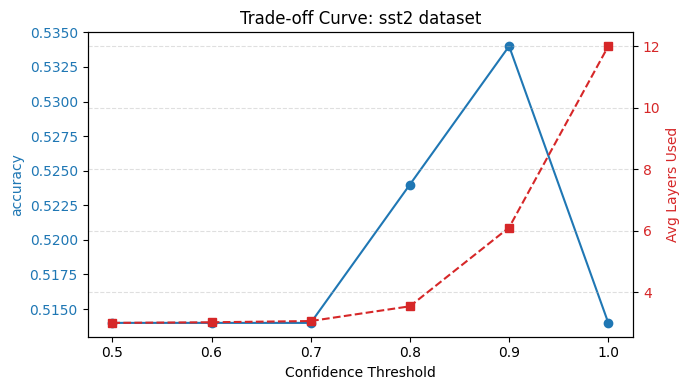

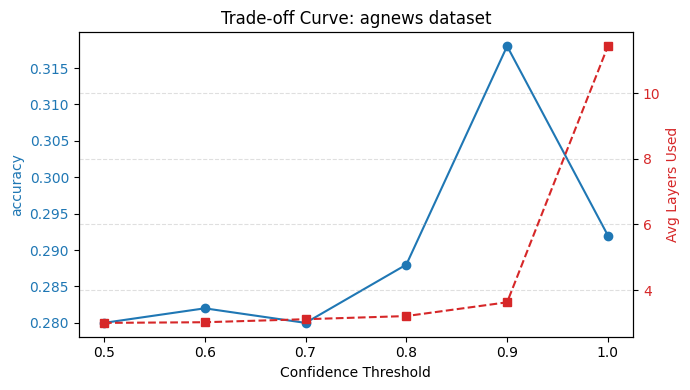

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Convert results_table into a dict grouped by dataset
grouped = {}
for row in results_table:
    ds = row["dataset"]
    if ds not in grouped:
        grouped[ds] = {
            "thresholds": [],
            "scores": [],
            "avg_layers_used": [],
            "metric_name": row["metric"],
        }
    grouped[ds]["thresholds"].append(row["threshold"])
    grouped[ds]["scores"].append(row["score"])
    grouped[ds]["avg_layers_used"].append(row["avg_layers_used"])


# ---- PLOT FOR EACH DATASET ----
for dataset_name, data in grouped.items():

    thresholds = data["thresholds"]
    scores     = data["scores"]
    layers     = data["avg_layers_used"]
    metric     = data["metric_name"]

    fig, ax1 = plt.subplots(figsize=(7, 4))

    # Left Y-axis → Accuracy / Score
    ax1.set_xlabel("Confidence Threshold")
    ax1.set_ylabel(metric, color="tab:blue")
    ax1.plot(thresholds, scores, marker="o", color="tab:blue", label=metric)
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Right Y-axis → Avg Layers Used
    ax2 = ax1.twinx()
    ax2.set_ylabel("Avg Layers Used", color="tab:red")
    ax2.plot(thresholds, layers, marker="s", linestyle="--", color="tab:red", label="Avg Layers")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    plt.title(f"Trade-off Curve: {dataset_name} dataset")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


In [ ]:
### Testing KV

In [2]:
### testing with KV similar to CALM paper
from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.cnn_dm import load_cnndm
from evaluation.dataset_loaders.squad import load_squad
from evaluation.dataset_loaders.wmt_en_fr import load_wmt_enfr

strategy = ConfidenceExit(threshold=0.5, allowed_layers=[3,6,9])
model = GPT2WithEarlyExit("gpt2", strategy, tokenizer, use_kv="True")

evaluator = EarlyExitEvaluator(tokenizer)

datasets = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
    ("cnn_dm", load_cnndm, "summarization"),
    ("wmt14_enfr", load_wmt_enfr, "translation"),
    ("squad", load_squad, "qa"),
]

for name, loader, task in datasets:
    print(f"Testing {name}...")

    dataset = loader(fraction=0.01)

    # ---------- IMPORTANT: pass dataset_name for classification ----------
    if task == "classification":
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
            dataset_name=name,      # e.g. "sst2" or "agnews"
        )
    else:
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
        )

    print(name, result)

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Testing sst2...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 58.62it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.625), 'avg_latency_sec': np.float64(0.016907483339309692), 'tokens_per_sec': 59.14540797890436, 'avg_layers_used': np.float64(4.0), 'num_samples': 8}
Testing agnews...


Evaluating: 100%|███████████████████████████████| 76/76 [00:01<00:00, 62.53it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.21052631578947367), 'avg_latency_sec': np.float64(0.015903350554014508), 'tokens_per_sec': 62.87983130369773, 'avg_layers_used': np.float64(4.0), 'num_samples': 76}
Testing cnn_dm...


Token indices sequence length is longer than the specified maximum sequence length for this model (1032 > 1024). Running this sequence through the model will result in indexing errors
Evaluating: 100%|█████████████████████████████| 114/114 [05:26<00:00,  2.86s/it]


cnn_dm {'metric': 'rougeL', 'score': np.float64(0.06416868659938631), 'avg_latency_sec': np.float64(2.8606659780468857), 'tokens_per_sec': 0.34956894921466786, 'avg_layers_used': np.float64(4.343624686716792), 'num_samples': 114}
Testing wmt14_enfr...


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Evaluating: 100%|███████████████████████████████| 30/30 [00:16<00:00,  1.83it/s]


wmt14_enfr {'metric': 'bleu', 'score': np.float64(0.0), 'avg_latency_sec': np.float64(0.5450647195180257), 'tokens_per_sec': 1.834644518699085, 'avg_layers_used': np.float64(4.334375), 'num_samples': 30}
Testing squad...


Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Evaluating: 100%|█████████████████████████████| 105/105 [01:43<00:00,  1.01it/s]

squad {'metric': 'token_f1', 'score': np.float64(0.010411728983157554), 'avg_latency_sec': np.float64(0.9888026169368199), 'tokens_per_sec': 1.0113241842925822, 'avg_layers_used': np.float64(4.398809523809524), 'num_samples': 105}


In [3]:
### testing without kv
from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.cnn_dm import load_cnndm
from evaluation.dataset_loaders.squad import load_squad
from evaluation.dataset_loaders.wmt_en_fr import load_wmt_enfr

strategy = ConfidenceExit(threshold=0.5, allowed_layers=[3,6,9])
model = GPT2WithEarlyExit("gpt2", strategy, tokenizer)

evaluator = EarlyExitEvaluator(tokenizer)

datasets = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
    ("cnn_dm", load_cnndm, "summarization"),
    ("wmt14_enfr", load_wmt_enfr, "translation"),
    ("squad", load_squad, "qa"),
]

for name, loader, task in datasets:
    print(f"Testing {name}...")

    dataset = loader(number=500)

    # pass dataset_name for classification
    if task == "classification":
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
            dataset_name=name,      # e.g. "sst2" or "agnews"
        )
    else:
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
        )

    print(name, result)

Testing sst2...


Evaluating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 57.20it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.625), 'avg_latency_sec': np.float64(0.017358005046844482), 'tokens_per_sec': 57.61030701980297, 'avg_layers_used': np.float64(4.0), 'num_samples': 8}
Testing agnews...


Evaluating: 100%|███████████████████████████████| 76/76 [00:01<00:00, 62.68it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.21052631578947367), 'avg_latency_sec': np.float64(0.015866188626540333), 'tokens_per_sec': 63.027109001290924, 'avg_layers_used': np.float64(4.0), 'num_samples': 76}
Testing cnn_dm...


Evaluating: 100%|█████████████████████████████| 114/114 [05:38<00:00,  2.97s/it]


cnn_dm {'metric': 'rougeL', 'score': np.float64(0.06416868659938631), 'avg_latency_sec': np.float64(2.9700791961268376), 'tokens_per_sec': 0.3366913587031822, 'avg_layers_used': np.float64(4.343624686716792), 'num_samples': 114}
Testing wmt14_enfr...


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating: 100%|███████████████████████████████| 30/30 [00:16<00:00,  1.80it/s]


wmt14_enfr {'metric': 'bleu', 'score': np.float64(0.0), 'avg_latency_sec': np.float64(0.5566605567932129), 'tokens_per_sec': 1.796426902888106, 'avg_layers_used': np.float64(4.334375), 'num_samples': 30}
Testing squad...


Evaluating: 100%|█████████████████████████████| 105/105 [01:46<00:00,  1.02s/it]

squad {'metric': 'token_f1', 'score': np.float64(0.010411728983157554), 'avg_latency_sec': np.float64(1.0161871455964588), 'tokens_per_sec': 0.9840707042333647, 'avg_layers_used': np.float64(4.398809523809524), 'num_samples': 105}


In [ ]:
### testing without kv
strategy = ConfidenceExit(threshold=0.1, allowed_layers=[2,4,6,8,10])
model = GPT2WithEarlyExit("gpt2", strategy, tokenizer, use_kv="False")

evaluator = EarlyExitEvaluator(tokenizer)

datasets = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
    ("cnn_dm", load_cnndm, "summarization"),
    ("wmt14_enfr", load_wmt_enfr, "translation"),
    ("squad", load_squad, "qa"),
]

for name, loader, task in datasets:
    print(f"Testing {name}...")

    dataset = loader(fraction=0.02)

    # pass dataset_name for classification
    if task == "classification":
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
            dataset_name=name,      # e.g. "sst2" or "agnews"
        )
    else:
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
        )

    print(name, result)

In [11]:
### testing without kv
strategy = ConfidenceExit(threshold=0.1, allowed_layers=[2,4,6,8,10])
model = GPT2WithEarlyExit("gpt2", strategy, tokenizer, use_kv="False")

evaluator = EarlyExitEvaluator(tokenizer)

datasets = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
    ("cnn_dm", load_cnndm, "summarization"),
    ("wmt14_enfr", load_wmt_enfr, "translation"),
    ("squad", load_squad, "qa"),
]

for name, loader, task in datasets:
    print(f"Testing {name}...")

    dataset = loader(fraction=0.005)

    # pass dataset_name for classification
    if task == "classification":
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
            dataset_name=name,      # e.g. "sst2" or "agnews"
        )
    else:
        result = evaluator.evaluate(
            model=model,
            strategy=strategy,
            dataset=dataset,
            task_type=task,
        )

    print(name, result)

Testing sst2...


Evaluating: 100%|█████████████████████████████████| 4/4 [00:00<00:00, 53.81it/s]


sst2 {'metric': 'accuracy', 'score': np.float64(0.75), 'avg_latency_sec': np.float64(0.01846897602081299), 'tokens_per_sec': 54.14485344899922, 'avg_layers_used': np.float64(3.0), 'num_samples': 4}
Testing agnews...


Evaluating: 100%|███████████████████████████████| 38/38 [00:00<00:00, 75.34it/s]


agnews {'metric': 'accuracy', 'score': np.float64(0.15789473684210525), 'avg_latency_sec': np.float64(0.013190169083444695), 'tokens_per_sec': 75.81403950728156, 'avg_layers_used': np.float64(3.0), 'num_samples': 38}
Testing cnn_dm...


Evaluating: 100%|███████████████████████████████| 57/57 [00:32<00:00,  1.75it/s]


cnn_dm {'metric': 'rougeL', 'score': np.float64(0.050215135413532744), 'avg_latency_sec': np.float64(0.5711161128261633), 'tokens_per_sec': 1.7509574279939475, 'avg_layers_used': np.float64(3.0), 'num_samples': 57}
Testing wmt14_enfr...


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating: 100%|███████████████████████████████| 15/15 [00:05<00:00,  2.59it/s]


wmt14_enfr {'metric': 'bleu', 'score': np.float64(0.0), 'avg_latency_sec': np.float64(0.3851939678192139), 'tokens_per_sec': 2.596094652420253, 'avg_layers_used': np.float64(3.0), 'num_samples': 15}
Testing squad...


Evaluating: 100%|███████████████████████████████| 52/52 [00:18<00:00,  2.76it/s]

squad {'metric': 'token_f1', 'score': np.float64(0.005145796465739077), 'avg_latency_sec': np.float64(0.3616780317746676), 'tokens_per_sec': 2.7648900738959434, 'avg_layers_used': np.float64(3.0), 'num_samples': 52}


In [ ]:
### Strategy 2 - Confidence threshold should be (meet) in Continous layers

In [7]:
from strategies.continous_confidence_exit import ContinuousConfidenceExit

strategy = ContinuousConfidenceExit(
    threshold=0.75,
    required_consecutive=2,
    allowed_layers=[3, 6, 9, 11]
)

model = GPT2WithEarlyExit("gpt2", strategy, tokenizer)
evaluator = EarlyExitEvaluator(tokenizer)